# Minor Project 5 - Boosting Techniques


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## Classification

## Import Dataset

In [3]:
df = pd.read_csv("/content/framingham.csv")

## Initial Analysis

In [4]:
print(df.head())

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
None


In [6]:
print(df.describe())

              male          age    education  currentSmoker   cigsPerDay  \
count  4238.000000  4238.000000  4133.000000    4238.000000  4209.000000   
mean      0.429212    49.584946     1.978950       0.494101     9.003089   
std       0.495022     8.572160     1.019791       0.500024    11.920094   
min       0.000000    32.000000     1.000000       0.000000     0.000000   
25%       0.000000    42.000000     1.000000       0.000000     0.000000   
50%       0.000000    49.000000     2.000000       0.000000     0.000000   
75%       1.000000    56.000000     3.000000       1.000000    20.000000   
max       1.000000    70.000000     4.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4185.000000      4238.000000   4238.000000  4238.000000  4188.000000   
mean      0.029630         0.005899      0.310524     0.025720   236.721585   
std       0.169584         0.076587      0.462763     0.158316    44.590334   

## Check for Duplicates

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB
None



## Outlier Detection and Correction






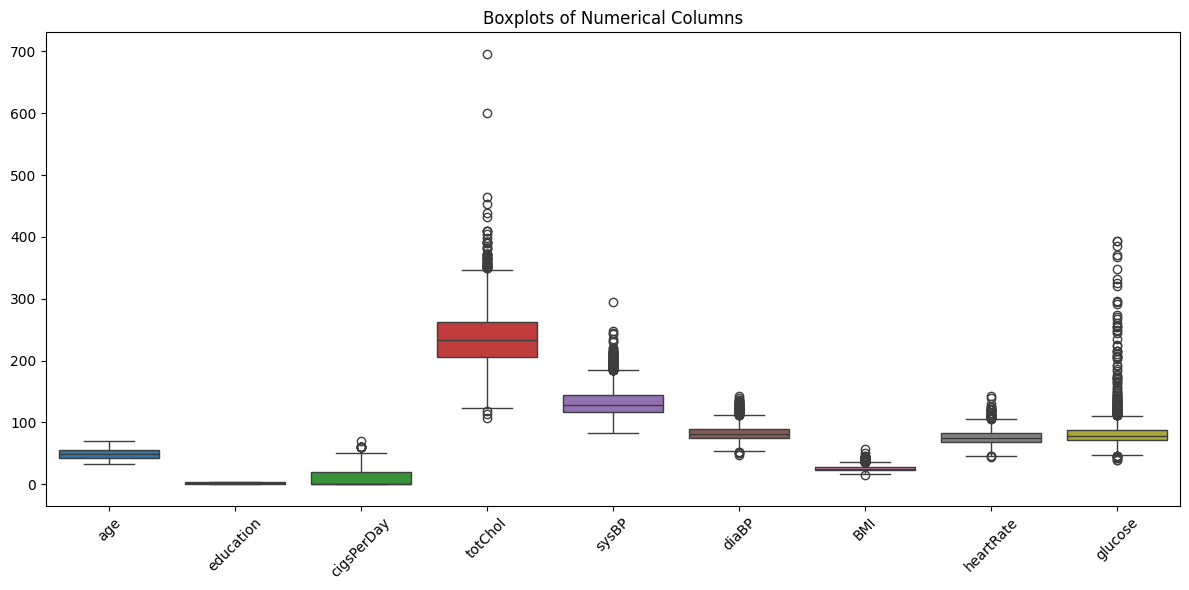

In [9]:
num_cols = df.select_dtypes(include = ["float64", "int64"]).columns.tolist()
bool_cols = [col for col in num_cols if set(df[col].unique()) <= {0, 1}]

num_cols = [col for col in num_cols if col not in bool_cols]

if 'BPMeds' in num_cols:
    num_cols.remove('BPMeds')

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[num_cols])
plt.xticks(rotation = 45)
plt.title("Boxplots of Numerical Columns")
plt.tight_layout()
plt.show()


In [10]:
def outlier_correction(df, col, show_plot = True):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

    return df

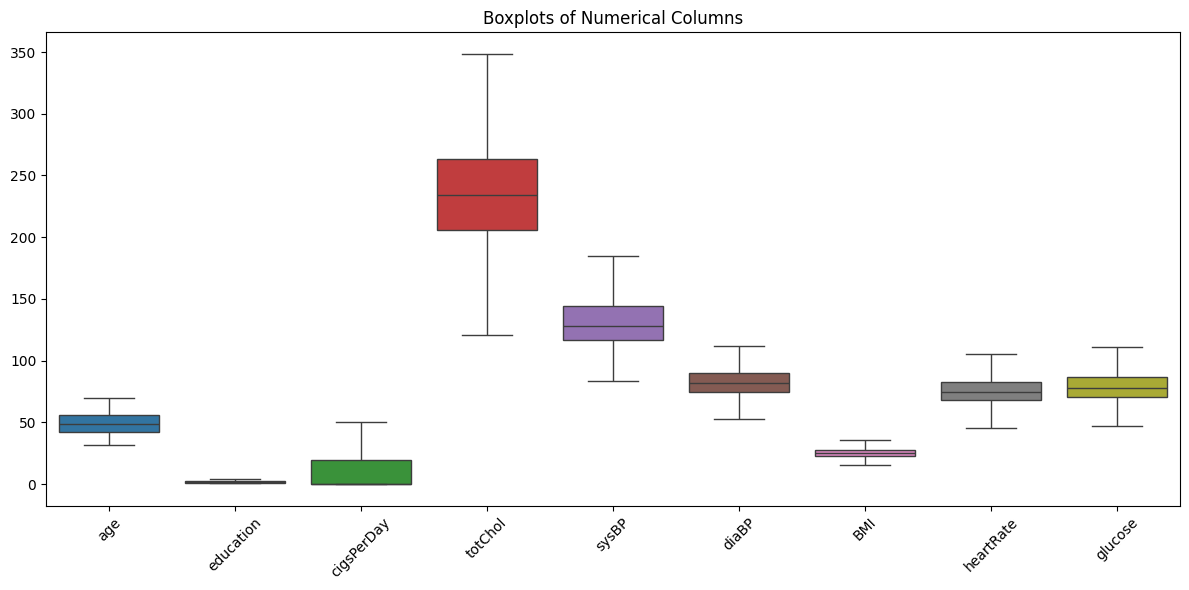

In [14]:
for col in num_cols:
    df = outlier_correction(df, col, show_plot = False)
plt.figure(figsize = (12, 6))
sns.boxplot(data = df[num_cols])
plt.xticks(rotation = 45)
plt.title("Boxplots of Numerical Columns")
plt.tight_layout()
plt.show()

## Handling Missing Values

In [16]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ["float64", "int64"]:
            df[col].fillna(df[col].mean(), inplace = True)
        else:
            df[col].fillna(df[col].mode()[0], inplace = True)


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   float64
 2   education        4238 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4238 non-null   float64
 5   BPMeds           4238 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4238 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4238 non-null   float64
 13  heartRate        4238 non-null   float64
 14  glucose          4238 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(10), int64(6)
memory usage: 529.9 KB
None


## Bivariate Analysis

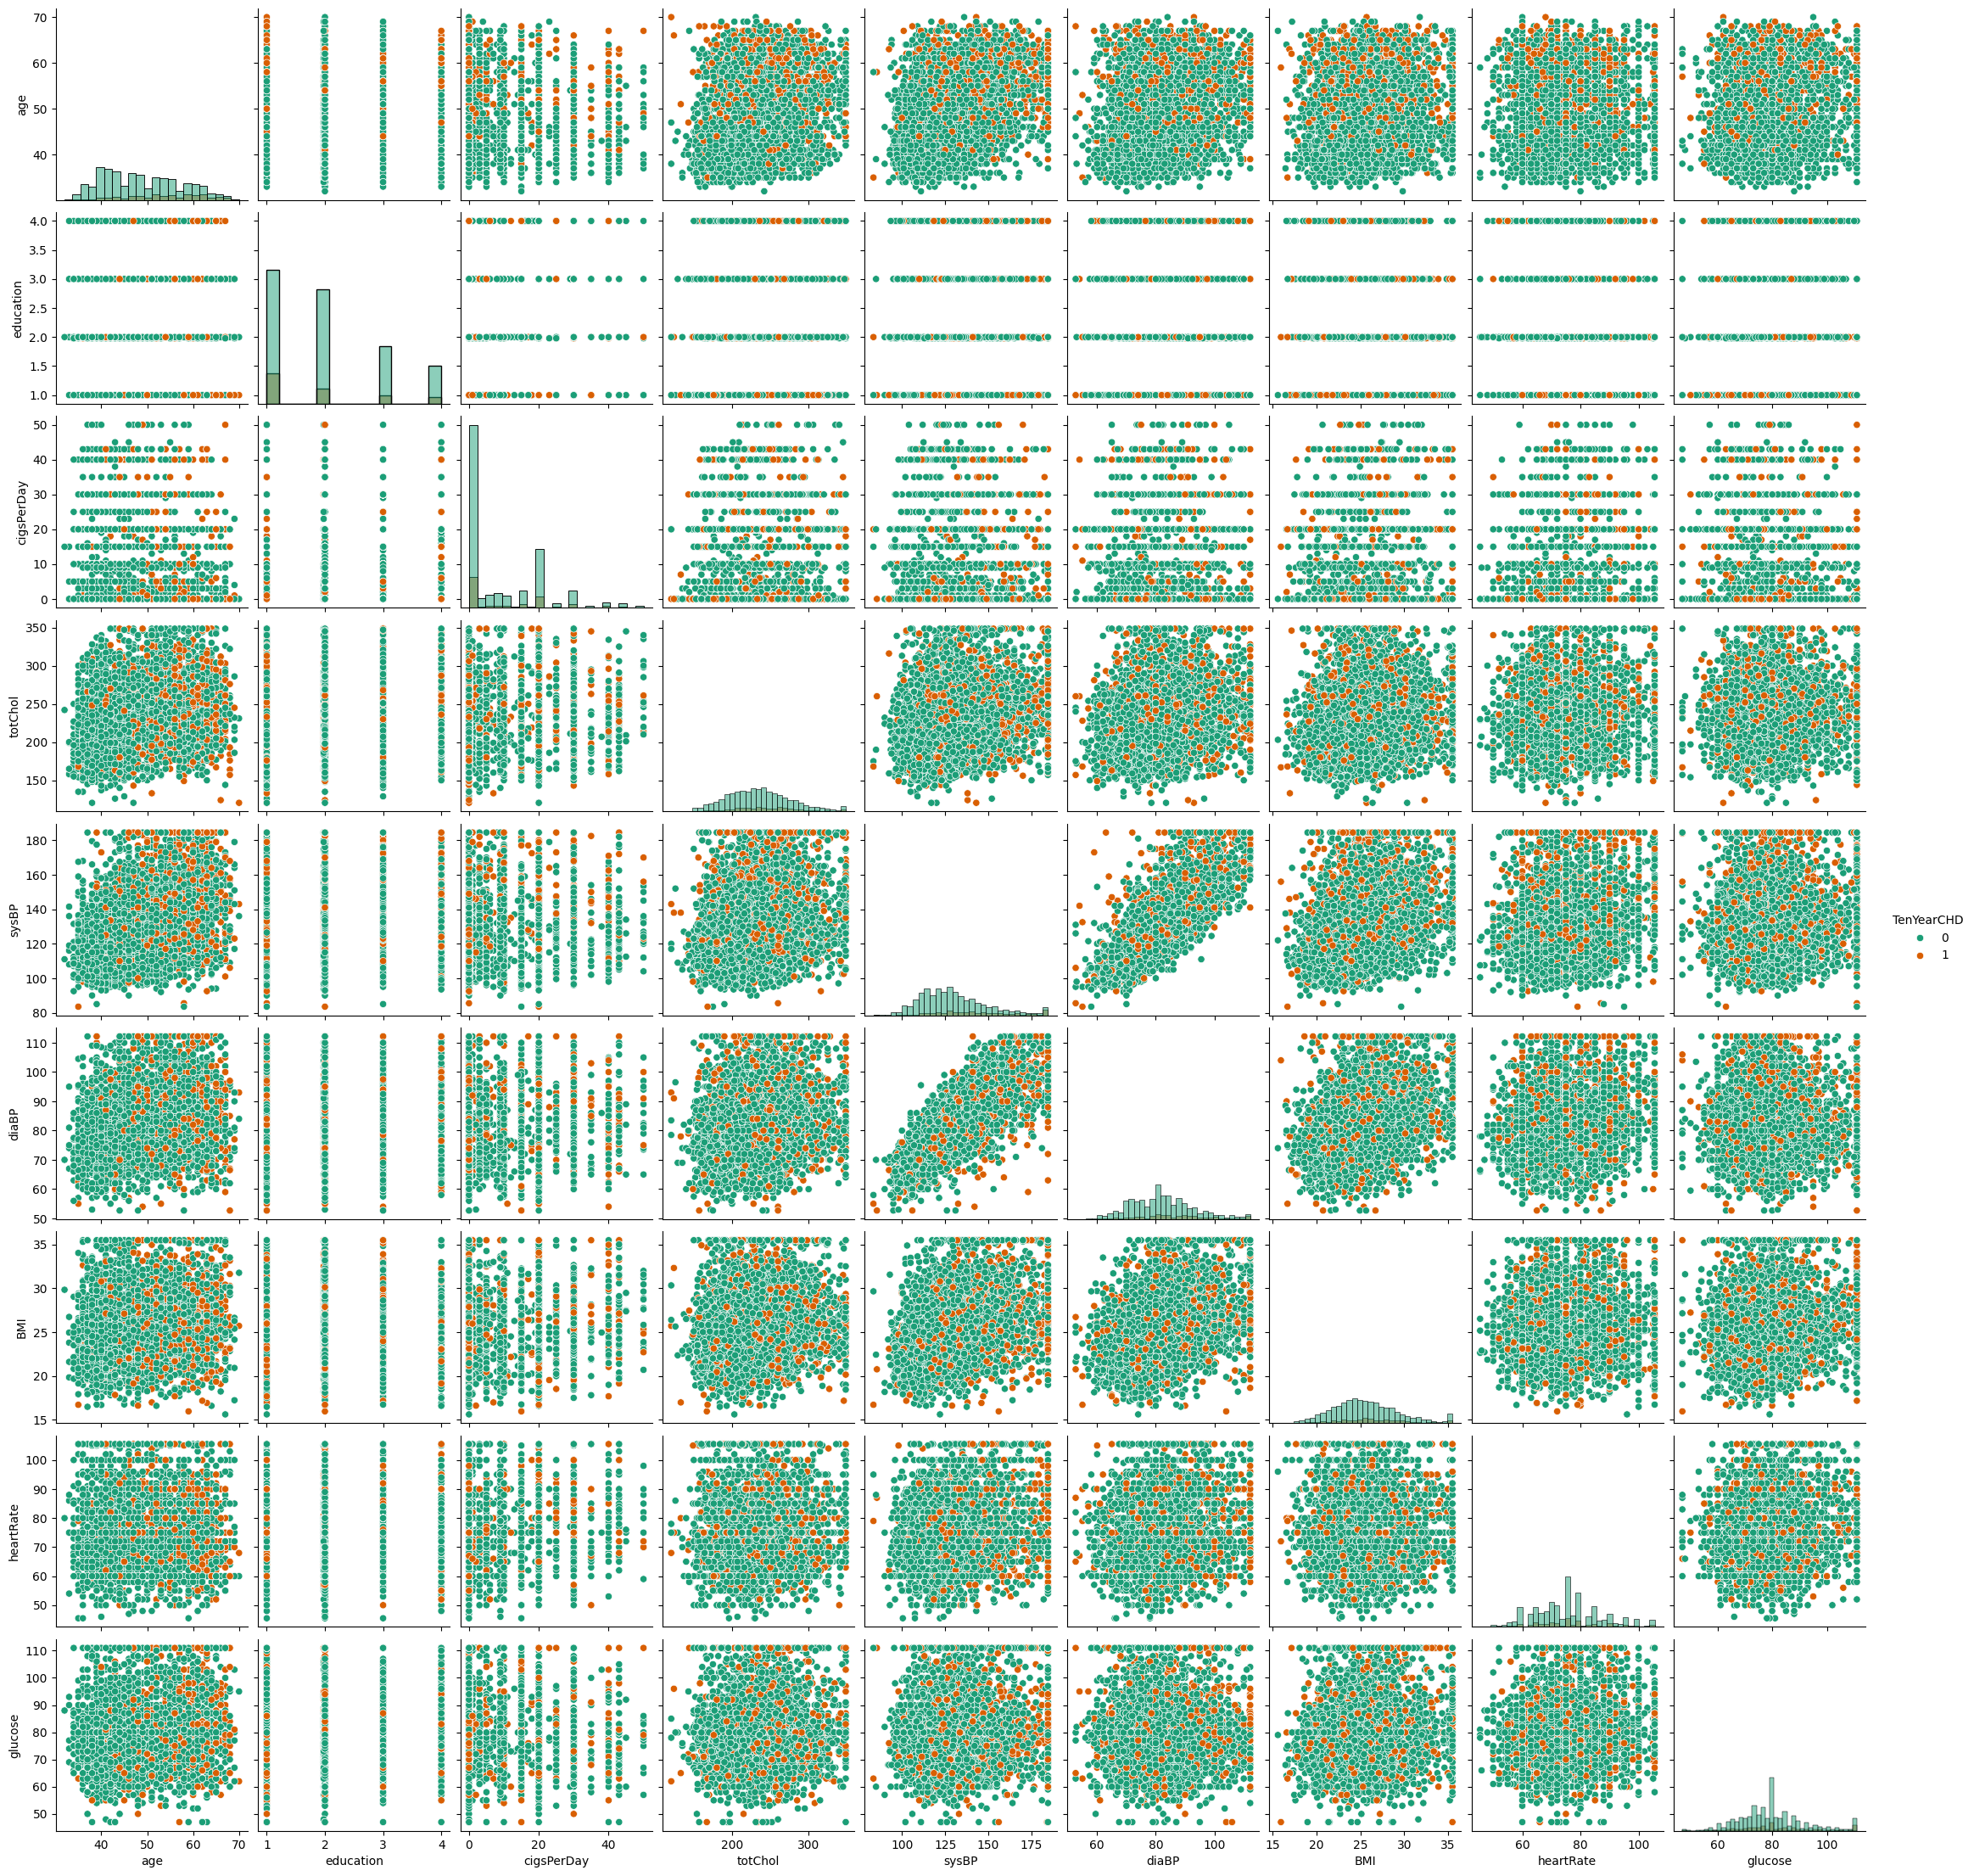

In [21]:
cols_for_pairplot = [col for col in num_cols if col != 'TenYearCHD'] + ['TenYearCHD']

sns.pairplot(df[cols_for_pairplot], hue = 'TenYearCHD', palette = 'Dark2', diag_kind = 'hist')
plt.show()


## Correlation and Heatmap

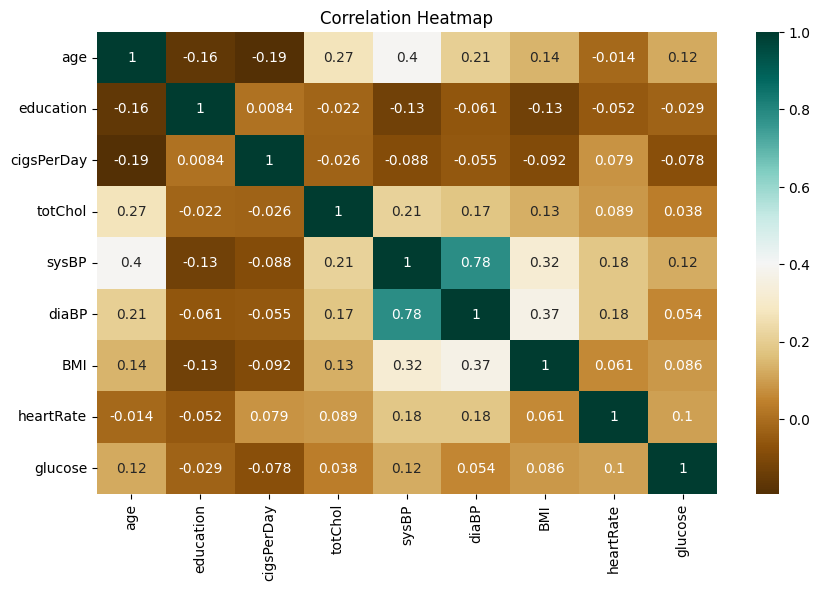

In [22]:
plt.figure(figsize = (10,6))
sns.heatmap(df[num_cols].corr(), annot = True, cmap = "BrBG")
plt.title("Correlation Heatmap")
plt.show()

## Normalisation and Scaling

In [23]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


print(df.head())

   male       age  education  currentSmoker  cigsPerDay  BPMeds  \
0     1 -1.234951   2.007088              0   -0.763176     0.0   
1     0 -0.418257   0.020905              0   -0.763176     0.0   
2     1 -0.184916  -0.972187              1    0.938026     0.0   
3     0  1.331800   1.013996              1    1.788627     0.0   
4     0 -0.418257   1.013996              1    1.193206     0.0   

   prevalentStroke  prevalentHyp  diabetes   totChol     sysBP     diaBP  \
0                0             0         0 -0.973368 -1.255196 -1.118089   
1                0             0         0  0.324501 -0.528621 -0.152197   
2                0             0         0  0.206513 -0.213772 -0.240006   
3                0             1         0 -0.265439  0.876090  1.077119   
4                0             0         0  1.150418 -0.092676  0.111228   

        BMI  heartRate   glucose  TenYearCHD  
0  0.330564   0.365620 -0.239238           0  
1  0.795016   1.656276 -0.320951           0  

## Train Test Split

In [24]:
X = df.drop('TenYearCHD', axis = 1)
y = df['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## AdaBoost

In [25]:
model = AdaBoostClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [27]:
y_pred_train = model.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.8525073746312685
Confusion Matrix:
 [[2858   17]
 [ 483   32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      2875
           1       0.65      0.06      0.11       515

    accuracy                           0.85      3390
   macro avg       0.75      0.53      0.52      3390
weighted avg       0.82      0.85      0.80      3390



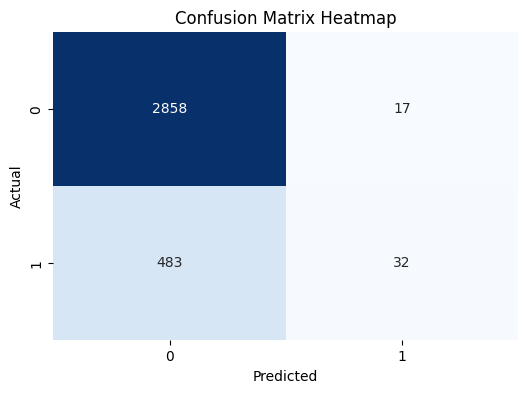

In [29]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [30]:
y_pred = model.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8443396226415094
Confusion Matrix:
 [[710   9]
 [123   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       719
           1       0.40      0.05      0.08       129

    accuracy                           0.84       848
   macro avg       0.63      0.52      0.50       848
weighted avg       0.78      0.84      0.79       848



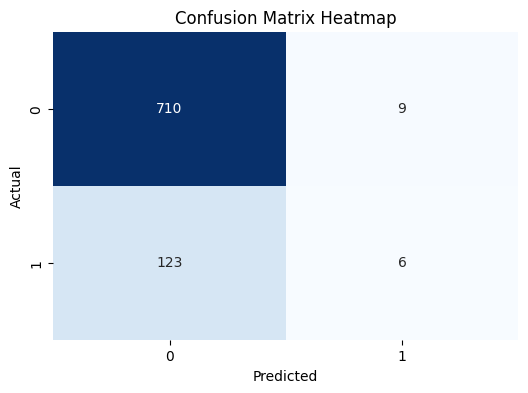

In [31]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Fine tuning

In [33]:
model = AdaBoostClassifier(random_state = 42)

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [34]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 1, 'n_estimators': 200}


In [35]:
best_rf = grid_search.best_estimator_

In [36]:
y_pred_train = best_rf.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.8557522123893805
Confusion Matrix:
 [[2860   15]
 [ 474   41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      2875
           1       0.73      0.08      0.14       515

    accuracy                           0.86      3390
   macro avg       0.79      0.54      0.53      3390
weighted avg       0.84      0.86      0.80      3390



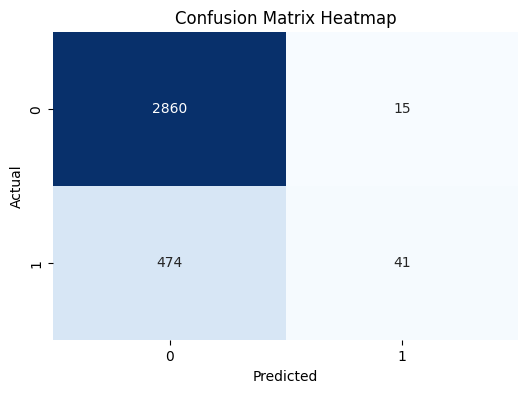

In [37]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [38]:
y_pred = best_rf.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.847877358490566
Confusion Matrix:
 [[712   7]
 [122   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92       719
           1       0.50      0.05      0.10       129

    accuracy                           0.85       848
   macro avg       0.68      0.52      0.51       848
weighted avg       0.80      0.85      0.79       848



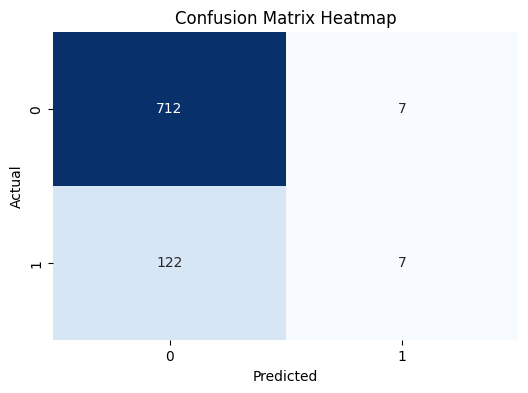

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [40]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 age                0.392495
totChol            0.115074
diaBP              0.109269
sysBP              0.108943
cigsPerDay         0.082511
BMI                0.071189
heartRate          0.041460
male               0.021117
prevalentStroke    0.019575
diabetes           0.016464
dtype: float64


## Gradient Boost

In [41]:
model = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [42]:
y_pred_train = model.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.8787610619469026
Confusion Matrix:
 [[2872    3]
 [ 408  107]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      2875
           1       0.97      0.21      0.34       515

    accuracy                           0.88      3390
   macro avg       0.92      0.60      0.64      3390
weighted avg       0.89      0.88      0.84      3390



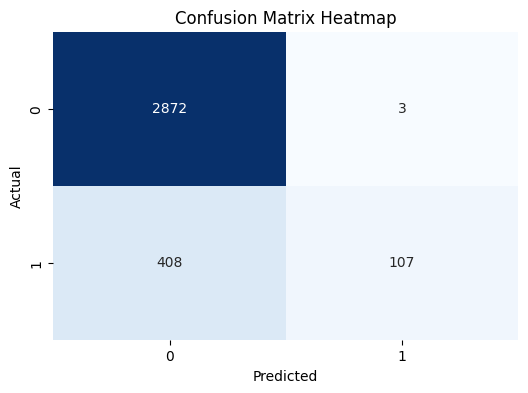

In [43]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [44]:
y_pred = model.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8349056603773585
Confusion Matrix:
 [[702  17]
 [123   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       719
           1       0.26      0.05      0.08       129

    accuracy                           0.83       848
   macro avg       0.56      0.51      0.49       848
weighted avg       0.76      0.83      0.78       848



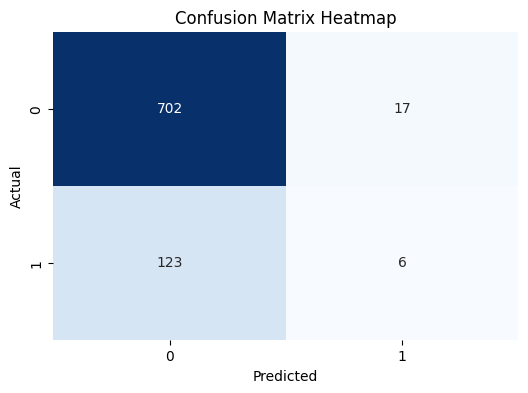

In [45]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Fine tuning

In [46]:
model = GradientBoostingClassifier(random_state = 42)

param_grid = {
   "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [47]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [48]:
best_rf = grid_search.best_estimator_

In [49]:
y_pred_train = best_rf.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.8634218289085546
Confusion Matrix:
 [[2874    1]
 [ 462   53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      2875
           1       0.98      0.10      0.19       515

    accuracy                           0.86      3390
   macro avg       0.92      0.55      0.56      3390
weighted avg       0.88      0.86      0.81      3390



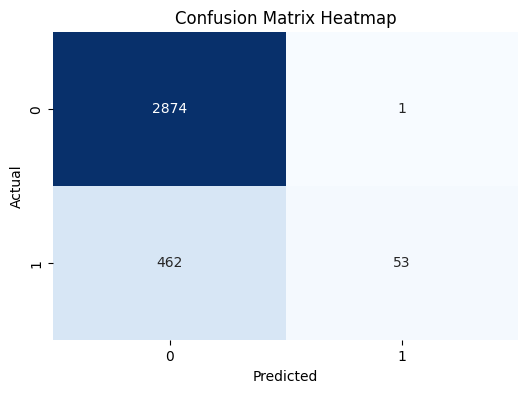

In [50]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [51]:
y_pred = best_rf.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.839622641509434
Confusion Matrix:
 [[710   9]
 [127   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       719
           1       0.18      0.02      0.03       129

    accuracy                           0.84       848
   macro avg       0.52      0.50      0.47       848
weighted avg       0.75      0.84      0.78       848



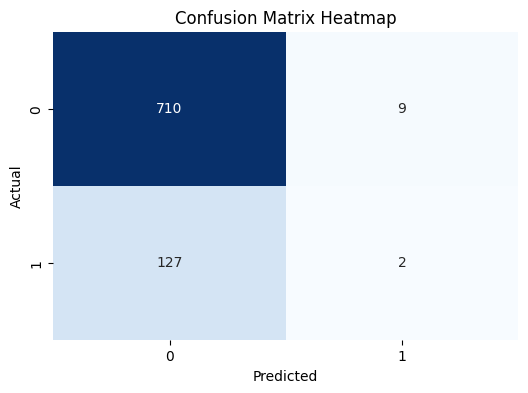

In [52]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [53]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 age             0.331312
sysBP           0.190361
cigsPerDay      0.100460
diaBP           0.084087
totChol         0.074162
male            0.047496
BMI             0.044191
glucose         0.036885
prevalentHyp    0.021664
BPMeds          0.020203
dtype: float64


## XGBoost

In [54]:
model = XGBClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [55]:
y_pred_train = model.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.9929203539823008
Confusion Matrix:
 [[2875    0]
 [  24  491]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2875
           1       1.00      0.95      0.98       515

    accuracy                           0.99      3390
   macro avg       1.00      0.98      0.99      3390
weighted avg       0.99      0.99      0.99      3390



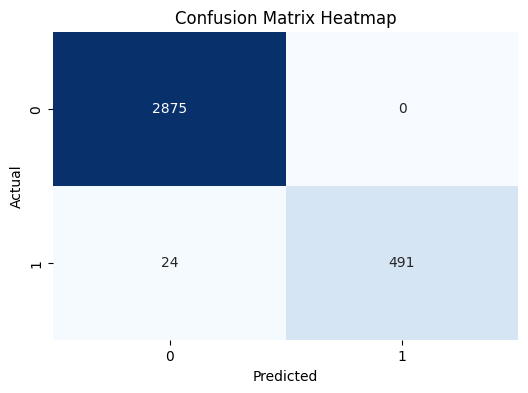

In [56]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [57]:
y_pred = model.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8136792452830188
Confusion Matrix:
 [[681  38]
 [120   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       719
           1       0.19      0.07      0.10       129

    accuracy                           0.81       848
   macro avg       0.52      0.51      0.50       848
weighted avg       0.75      0.81      0.78       848



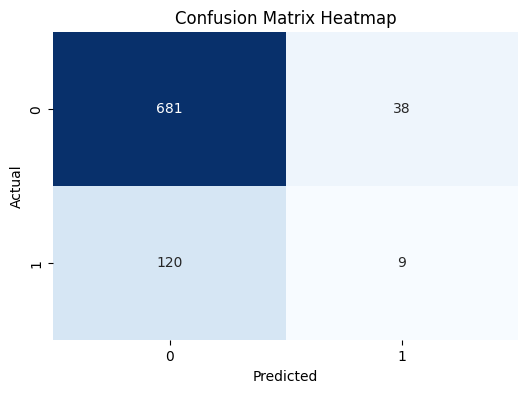

In [58]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Fine tuning

In [59]:
model = XGBClassifier(random_state = 42)

param_grid = {
   "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [60]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [61]:
best_rf = grid_search.best_estimator_

In [62]:
y_pred_train = best_rf.predict(X_train)
print("Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy Score: 0.8710914454277287
Confusion Matrix:
 [[2873    2]
 [ 435   80]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2875
           1       0.98      0.16      0.27       515

    accuracy                           0.87      3390
   macro avg       0.92      0.58      0.60      3390
weighted avg       0.88      0.87      0.83      3390



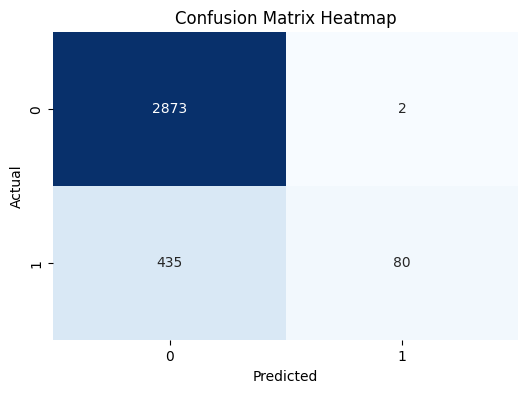

In [63]:
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [64]:
y_pred = best_rf.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8466981132075472
Confusion Matrix:
 [[713   6]
 [124   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92       719
           1       0.45      0.04      0.07       129

    accuracy                           0.85       848
   macro avg       0.65      0.52      0.49       848
weighted avg       0.79      0.85      0.79       848



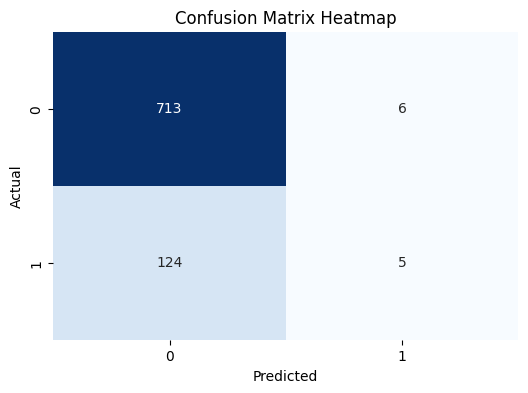

In [65]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [66]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 prevalentHyp       0.180924
age                0.162951
BPMeds             0.095129
sysBP              0.067124
cigsPerDay         0.066186
male               0.062644
diaBP              0.046618
glucose            0.044311
prevalentStroke    0.043444
diabetes           0.042729
dtype: float32


## Regression

## Import Dataset

In [4]:
df = pd.read_csv("/content/co2.csv")

## Initial Analysis

In [5]:
print(df.head())

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                   

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [7]:
print(df.describe())

       Engine Size(L)    Cylinders  Fuel Consumption City (L/100 km)  \
count     7385.000000  7385.000000                       7385.000000   
mean         3.160068     5.615030                         12.556534   
std          1.354170     1.828307                          3.500274   
min          0.900000     3.000000                          4.200000   
25%          2.000000     4.000000                         10.100000   
50%          3.000000     6.000000                         12.100000   
75%          3.700000     6.000000                         14.600000   
max          8.400000    16.000000                         30.600000   

       Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
count                      7385.000000                       7385.000000   
mean                          9.041706                         10.975071   
std                           2.224456                          2.892506   
min                           4.000000         

## Check for Duplicates

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6282 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              6282 non-null   object 
 1   Model                             6282 non-null   object 
 2   Vehicle Class                     6282 non-null   object 
 3   Engine Size(L)                    6282 non-null   float64
 4   Cylinders                         6282 non-null   int64  
 5   Transmission                      6282 non-null   object 
 6   Fuel Type                         6282 non-null   object 
 7   Fuel Consumption City (L/100 km)  6282 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   6282 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  6282 non-null   float64
 10  Fuel Consumption Comb (mpg)       6282 non-null   int64  
 11  CO2 Emissions(g/km)               6282 non-null   int64  
dtypes: float64(


## Outlier Detection and Correction






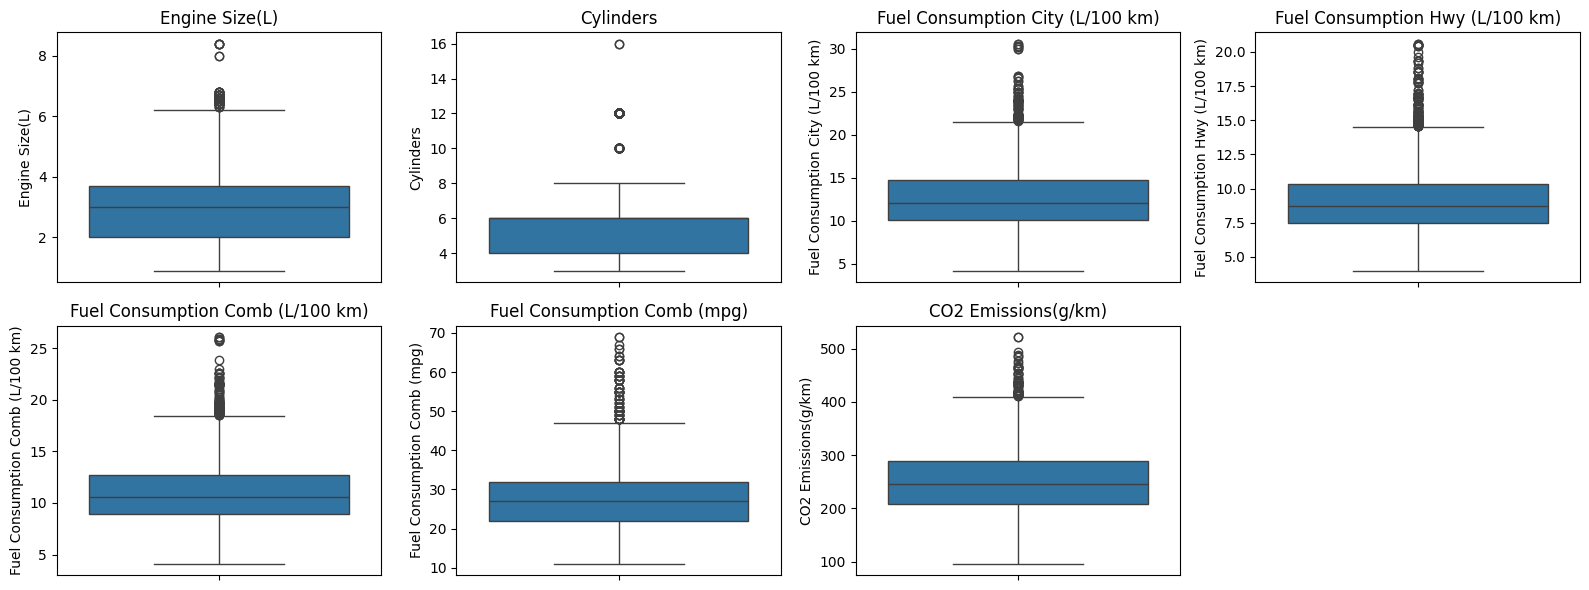

In [10]:
num_cols = df.select_dtypes(include = ["float64", "int64"]).columns.tolist()

n_cols = 4
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y = df[col], ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
def outlier_correction(df, col, show_plot = True):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

    return df

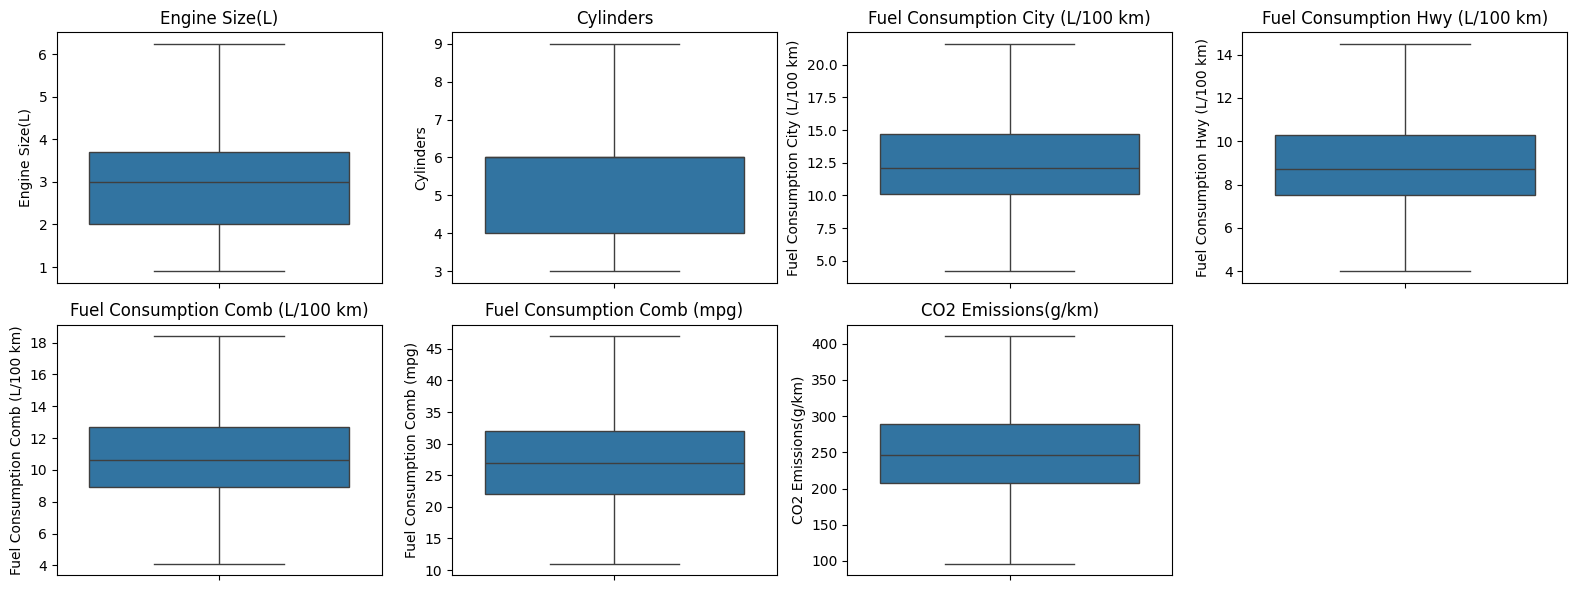

In [12]:
for col in num_cols:
    df = outlier_correction(df, col, show_plot=False)

n_cols = 4
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize = (4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y = df[col], ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Handling Missing Values

In [13]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ["float64", "int64"]:
            df[col].fillna(df[col].mean(), inplace = True)
        else:
            df[col].fillna(df[col].mode()[0], inplace = True)


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6282 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              6282 non-null   object 
 1   Model                             6282 non-null   object 
 2   Vehicle Class                     6282 non-null   object 
 3   Engine Size(L)                    6282 non-null   float64
 4   Cylinders                         6282 non-null   float64
 5   Transmission                      6282 non-null   object 
 6   Fuel Type                         6282 non-null   object 
 7   Fuel Consumption City (L/100 km)  6282 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   6282 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  6282 non-null   float64
 10  Fuel Consumption Comb (mpg)       6282 non-null   float64
 11  CO2 Emissions(g/km)               6282 non-null   float64
dtypes: float64(

## Bivariate Analysis

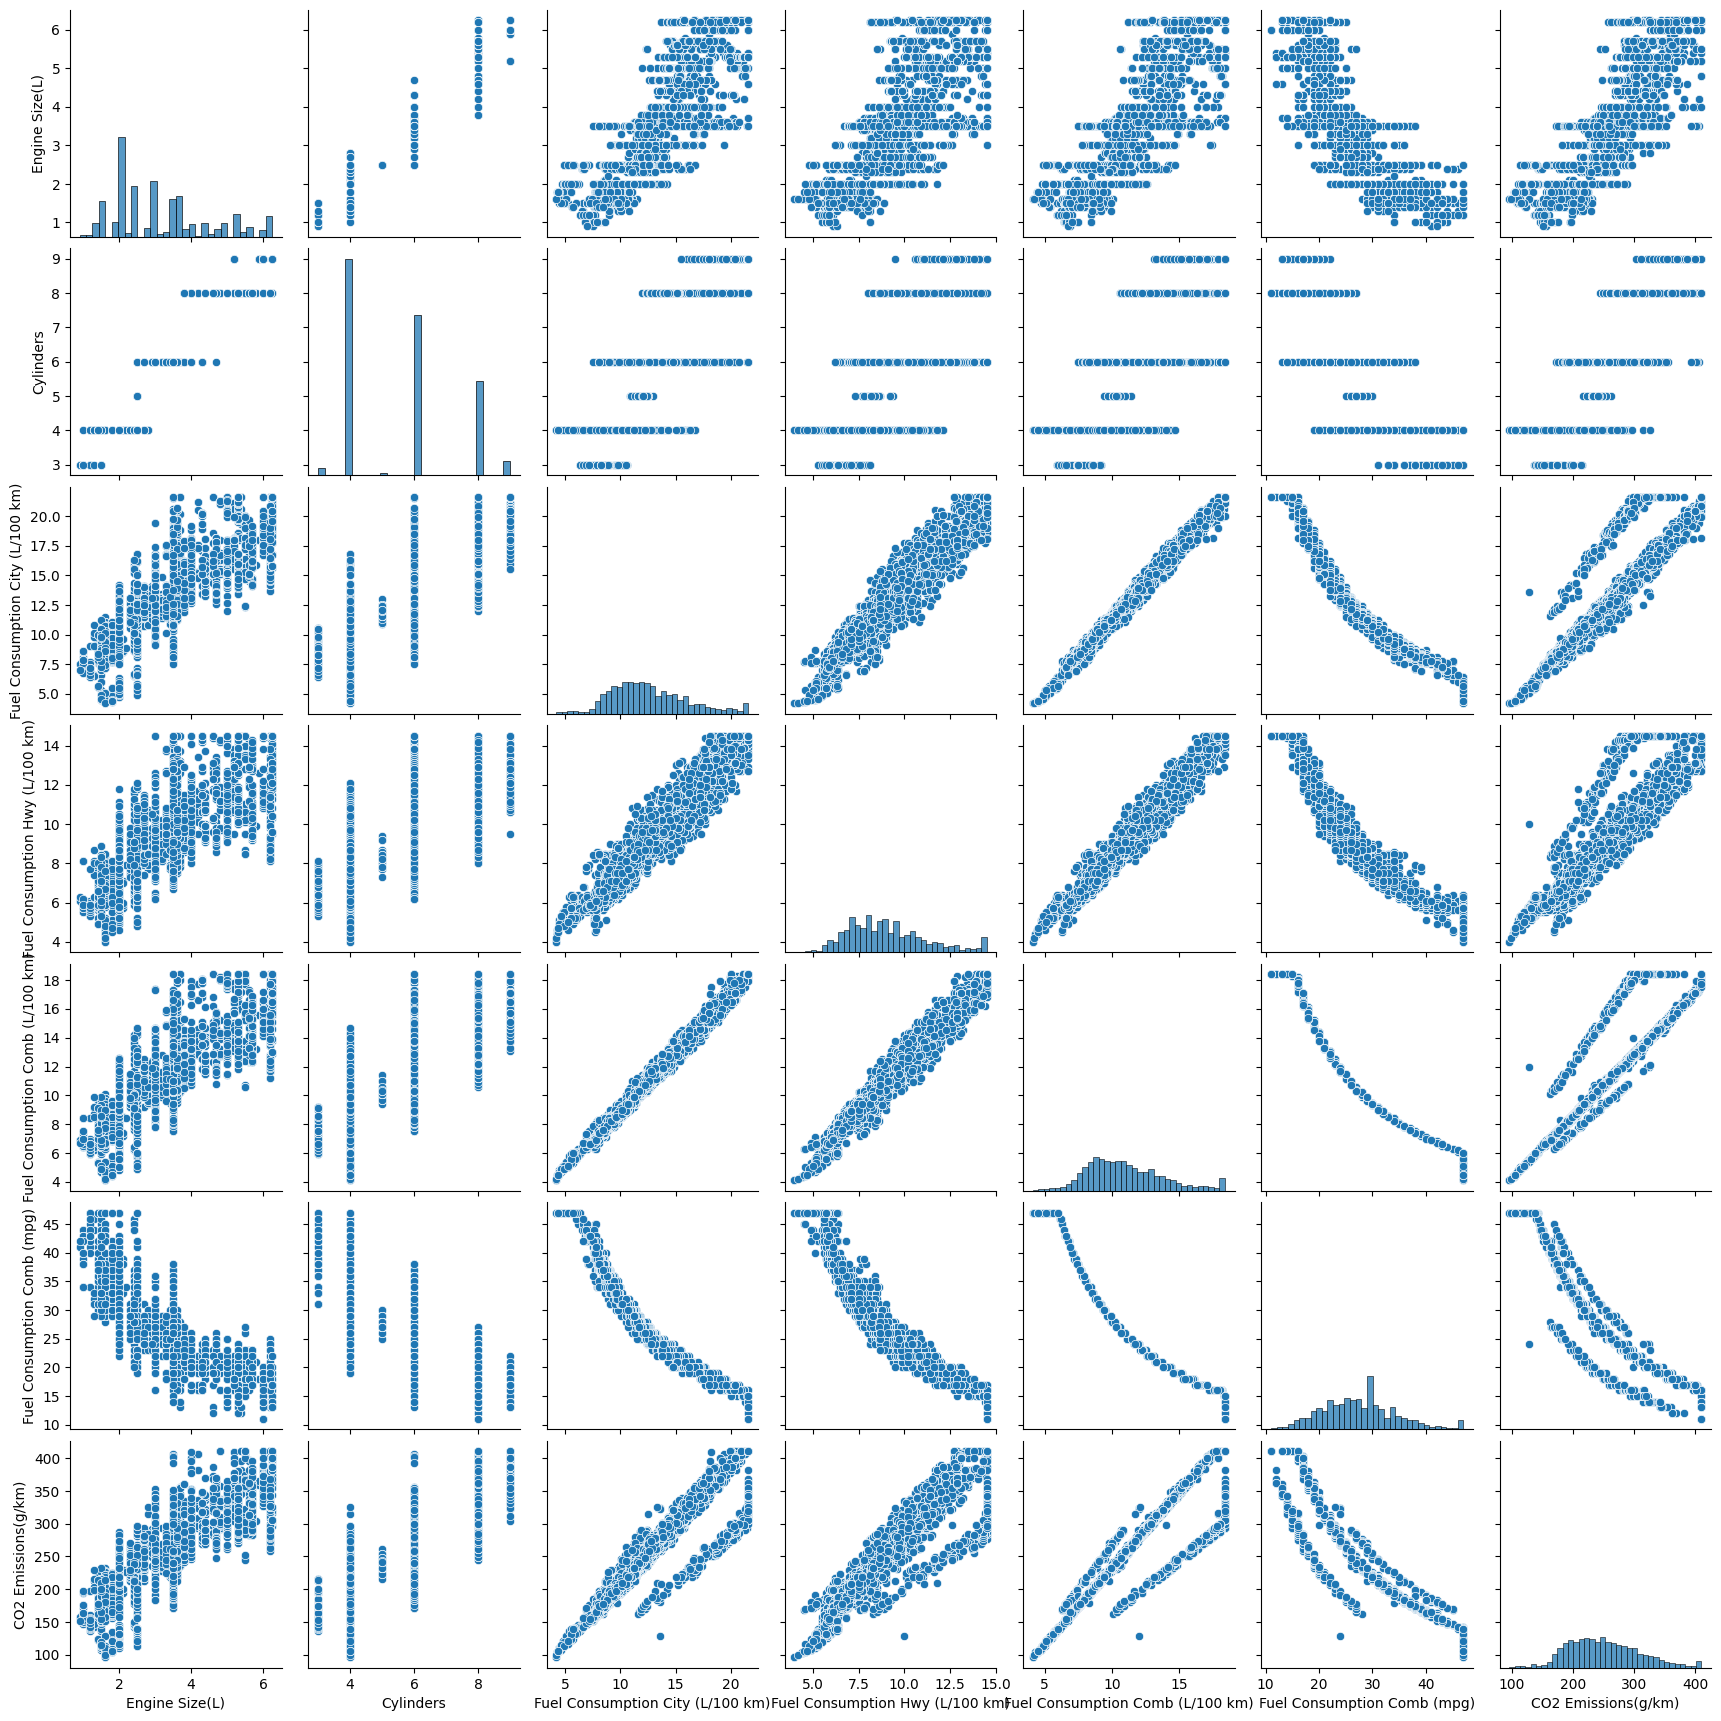

In [15]:
sns.pairplot(df[num_cols], diag_kind = 'hist')
plt.show()

## Correlation and Heatmap

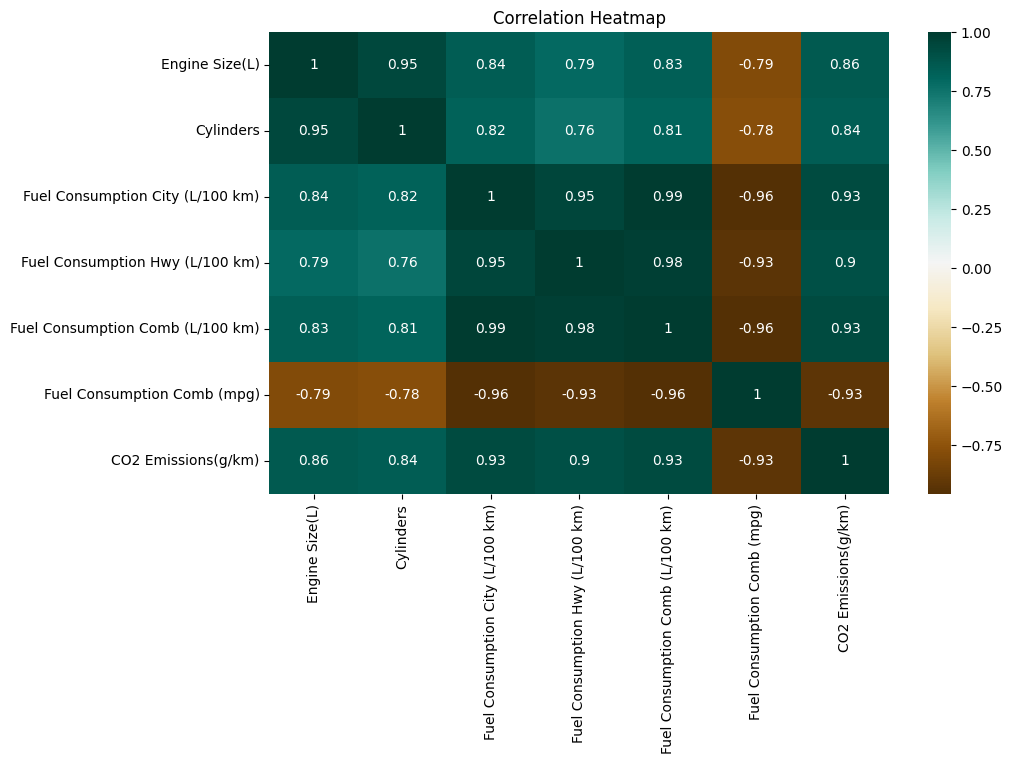

In [16]:
plt.figure(figsize = (10,6))
sns.heatmap(df[num_cols].corr(), annot = True, cmap = "BrBG")
plt.title("Correlation Heatmap")
plt.show()

## Normalisation and Scaling

In [17]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


print(df.head())

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT       -0.858034  -0.941941          AS5   
1  ACURA         ILX       COMPACT       -0.560647  -0.941941           M6   
2  ACURA  ILX HYBRID       COMPACT       -1.229767  -0.941941          AV7   
3  ACURA     MDX 4WD   SUV - SMALL        0.257166   0.276733          AS6   
4  ACURA     RDX AWD   SUV - SMALL        0.257166   0.276733          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                         -0.779197   
1         Z                         -0.400067   
2         Z                         -1.916586   
3         Z                          0.037390   
4         Z                         -0.137593   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                        -1.089352                         -0.878115   
1                        -0.621091                         -0.488642   
2                   

## Encoding

In [18]:
df = pd.get_dummies(df, drop_first = False).astype(int)

print(df.head())

   Engine Size(L)  Cylinders  Fuel Consumption City (L/100 km)  \
0               0          0                                 0   
1               0          0                                 0   
2              -1          0                                -1   
3               0          0                                 0   
4               0          0                                 0   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                               -1                                 0   
1                                0                                 0   
2                               -1                                -1   
3                                0                                 0   
4                                0                                 0   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  Make_ACURA  \
0                            0                    0           1   
1                            0      

## Train Test Split

In [19]:
X = df.drop(columns=['CO2 Emissions(g/km)'])
y = df['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## AdaBoost

In [20]:
model = AdaBoostRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100, random_state=42)

In [21]:
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0674
Root Mean Squared Error (RMSE): 0.2596
Mean Absolute Error (MAE): 0.1709
R-squared (R²): 0.8496


In [22]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0809
Root Mean Squared Error (RMSE): 0.2845
Mean Absolute Error (MAE): 0.1899
R-squared (R²): 0.8381


### Fine tuning

In [23]:
model = AdaBoostRegressor(random_state = 42)

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [24]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}


In [25]:
best_rf = grid_search.best_estimator_

In [26]:
y_pred_train = best_rf.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0611
Root Mean Squared Error (RMSE): 0.2471
Mean Absolute Error (MAE): 0.1113
R-squared (R²): 0.8637


In [27]:
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0746
Root Mean Squared Error (RMSE): 0.2731
Mean Absolute Error (MAE): 0.1281
R-squared (R²): 0.8508


In [28]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 Fuel Consumption Comb (mpg)         0.644825
Fuel Consumption Comb (L/100 km)    0.207629
Fuel Type_E                         0.088060
Fuel Consumption City (L/100 km)    0.039660
Cylinders                           0.012937
Fuel Consumption Hwy (L/100 km)     0.005571
Fuel Type_D                         0.001053
Vehicle Class_SUV - SMALL           0.000134
Make_LINCOLN                        0.000095
Model_E 250 BLUETEC 4MATIC          0.000034
dtype: float64


## Gradient Boost

In [29]:
model = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [30]:
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0361
Root Mean Squared Error (RMSE): 0.1901
Mean Absolute Error (MAE): 0.0905
R-squared (R²): 0.9193


In [31]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0525
Root Mean Squared Error (RMSE): 0.2290
Mean Absolute Error (MAE): 0.1130
R-squared (R²): 0.8951


### Fine tuning

In [32]:
model = GradientBoostingRegressor(random_state = 42)

param_grid = {
   "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [33]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [34]:
best_rf = grid_search.best_estimator_

In [35]:
y_pred_train = best_rf.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.1217
Root Mean Squared Error (RMSE): 0.3488
Mean Absolute Error (MAE): 0.1825
R-squared (R²): 0.7283


In [36]:
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.1438
Root Mean Squared Error (RMSE): 0.3793
Mean Absolute Error (MAE): 0.2048
R-squared (R²): 0.7123


In [37]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 Fuel Consumption Comb (mpg)         0.525509
Fuel Consumption Comb (L/100 km)    0.248805
Fuel Type_E                         0.077891
Cylinders                           0.050628
Fuel Consumption City (L/100 km)    0.046622
Fuel Consumption Hwy (L/100 km)     0.036032
Engine Size(L)                      0.005560
Fuel Type_D                         0.003394
Vehicle Class_VAN - PASSENGER       0.002548
Make_ROLLS-ROYCE                    0.001284
dtype: float64


## XGBoost

In [38]:
model = XGBRegressor(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0139
Root Mean Squared Error (RMSE): 0.1177
Mean Absolute Error (MAE): 0.0509
R-squared (R²): 0.9691


In [40]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.0456
Root Mean Squared Error (RMSE): 0.2134
Mean Absolute Error (MAE): 0.0895
R-squared (R²): 0.9089


### Fine tuning

In [41]:
model = XGBRegressor(random_state = 42)

param_grid = {
   "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [42]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [43]:
best_rf = grid_search.best_estimator_

In [44]:
y_pred_train = best_rf.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.1226
Root Mean Squared Error (RMSE): 0.3501
Mean Absolute Error (MAE): 0.1826
R-squared (R²): 0.7263


In [45]:
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Performance:
Mean Squared Error (MSE): 0.1447
Root Mean Squared Error (RMSE): 0.3804
Mean Absolute Error (MAE): 0.2048
R-squared (R²): 0.7106


In [46]:
feature_importances = pd.Series(best_rf.feature_importances_, index = X.columns)
feature_importances.sort_values(ascending = False, inplace = True)
print("\nTop 10 Important Features:\n", feature_importances.head(10))


Top 10 Important Features:
 Fuel Consumption Comb (mpg)         0.357773
Fuel Consumption Comb (L/100 km)    0.292240
Fuel Type_E                         0.095557
Cylinders                           0.076303
Fuel Consumption Hwy (L/100 km)     0.054385
Engine Size(L)                      0.044599
Fuel Consumption City (L/100 km)    0.026874
Vehicle Class_VAN - PASSENGER       0.015467
Make_ROLLS-ROYCE                    0.014708
Model_FOCUS FFV                     0.007216
dtype: float32
